In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import importlib
import copy
import time

In [2]:
print(torch.__version__)

1.0.1.post2


In [3]:
import deepretina
#import drone
from deepretina.core import load
from deepretina.experiments import rolling_window
from deepretina.metrics import cc
#
import pyret
import pyret.filtertools as ft
from pyret.nonlinearities import Binterp, RBF, Sigmoid
from pyret.visualizations import plot_sta
# ft.linear_response has a different dimension before version '0.6.0'
pyret.__version__
#pyret.visualizations.__all__

Using TensorFlow backend.


'0.6.0'

In [4]:
#from aesthetics.plotting import adjust_spines
from scipy.stats import sem, pearsonr
from scipy.stats.stats import zscore
from sklearn.cluster import KMeans
from tqdm import tqdm
import datetime
import os
import pickle
import re
import h5py
import collections
import sys
sys.path.append('~/Modules/deep-retina/')
sys.path.append('~/Modules/drone/')
from os import listdir
from os.path import isfile, join, isdir

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('deepretina2')
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.rcParams['animation.html'] = 'jshtml'
from IPython.display import HTML
%matplotlib inline

In [6]:
# My module
#sys.path.insert(0,'~/Modules/')
#sys.path.insert(0,'..') # include parent folder
import my
my.figure_setting()

['seaborn-dark', 'seaborn-whitegrid', 'seaborn-colorblind', 'classic', 'seaborn-ticks', 'seaborn-white', 'seaborn-bright', 'seaborn-dark-palette', 'seaborn-darkgrid', 'tableau-colorblind10', 'seaborn', 'fast', 'seaborn-deep', 'seaborn-pastel', 'dark_background', 'grayscale', 'ggplot', 'seaborn-talk', '_classic_test', 'seaborn-muted', 'seaborn-paper', 'seaborn-notebook', 'Solarize_Light2', 'fivethirtyeight', 'bmh', 'seaborn-poster']


## Data open

In [7]:
pwd

'/home/juyoung/Modules/1d-whitenoise-models'

### Juyoung's Data in /Module open

Data open steps should be straightforward and compact.
1. Given dir and list filenames
2. Select filename (e.g. h5) and list keys.
2. Assign stim and resp
3. compute rev corr or STA

In [33]:
data_dir = '/Users/peterfish/Modules/'
data_dir = '/home/juyoung/Modules/'
#
filename = 'data_filtered_5cells.h5'
filename = 'data_whitenoise_6cells.h5'
filename = 'data_filtered_0205.h5'
filename = 'data_smoothed_5.h5'
#filename = 'data_filtered_0406.h5'

In [34]:
# What keys in the h5?
with h5py.File(data_dir+filename, 'r') as f:
    print(list(f.keys()))
    dset = f['exp1']
    print('Keys  - ', list(dset.keys()))
    print('Attrs - ', list(dset.attrs.keys()))
    print(dset.attrs['Name'])
    #
    rdata = np.array(dset['rdata'])
    rdata_upsampled = np.array(dset['rdata_fliptimes'])
    rtime = np.array(dset['rtime'])
    stim_upsampled = np.array(dset['stim_res'], dtype='f')
    stim_resampled = np.array(dset['stim_rtime'], dtype='f')
    fliptimes = np.array(dset['fliptimes'])
    ifi = np.array(dset.attrs['ifi'])
    print(ifi)

['exp1']
Keys  -  ['fliptimes', 'rdata', 'rdata_fliptimes', 'roi_ids', 'rtime', 'stim_res', 'stim_rtime']
Attrs -  ['Name', 'roi', 'ifi', 'Smooth_size']
b'loc2_whitenoise_1_1 [ch1]'
[0.034403]


In [35]:
stim = stim_resampled
resp = rdata
print('stim (   frame, space) - ', stim.shape)
print('resp ( cell id, frame) - ', resp.shape)

stim (   frame, space) -  (16224, 24)
resp ( cell id, frame) -  (5, 16224)


#### Data centering

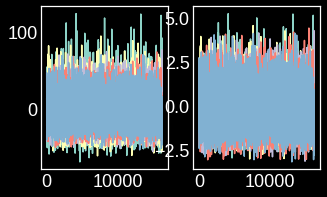

In [36]:
ax = plt.subplot(1,2,1)
ax.plot(resp.T)
resp = zscore(resp, axis=1)
ax = plt.subplot(1,2,2)
ax.plot(resp.T)

nbins =  35
Cell 1: w/ training data (0.302 and 0.311), w/ test data (0.152 and 0.160)


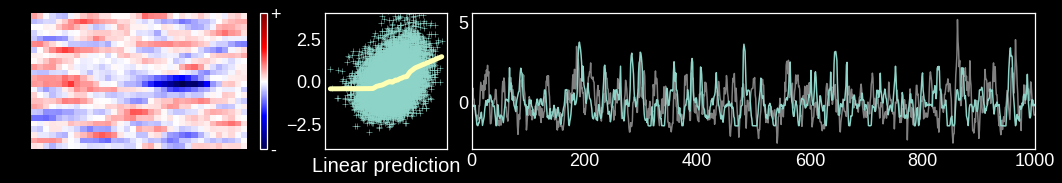

Cell 2: w/ training data (0.247 and 0.245), w/ test data (0.033 and 0.032)


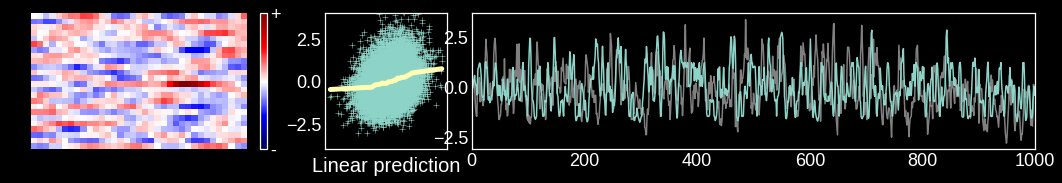

Cell 3: w/ training data (0.261 and 0.260), w/ test data (0.009 and -0.004)


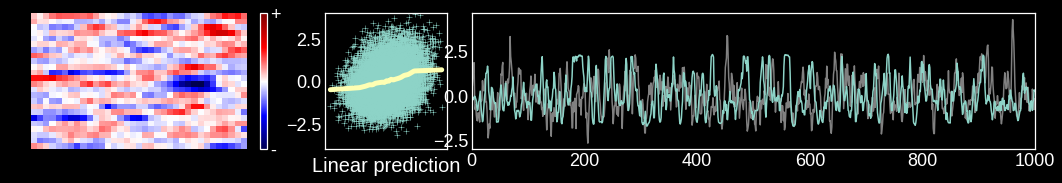

Cell 4: w/ training data (0.250 and 0.249), w/ test data (0.090 and 0.100)


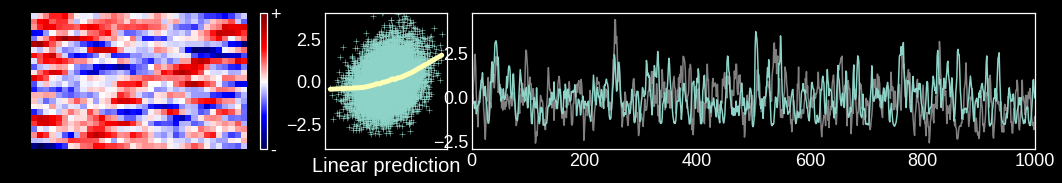

Cell 5: w/ training data (0.236 and 0.236), w/ test data (0.009 and 0.009)


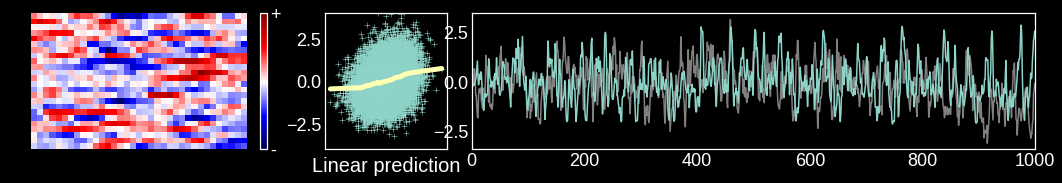

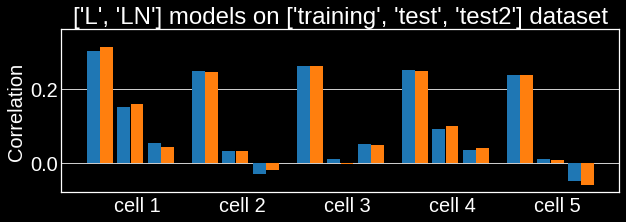

In [37]:
importlib.reload(my)
# trace = (cell id, trace)
# stim  = (frame, space dim)
assert resp.shape[0] < resp.shape[1], "1st dimension should be cell id."
#
model_r = my.LN_model_summary(resp, stim, nbins=1.2/ifi, n_testset=1000)

### David data open

In [62]:
data_dir = '/home/juyoung/Modules/Data/David/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
files = [f for f in files if '.h5' in f]
files

['amacrines_early_2012.h5', 'amacrines_late_2012.h5']

In [107]:
i = 1
filename = data_dir + files[i]
with h5py.File(filename, 'r') as f:
    #print(list(f['expts']))
    print(list(f.keys()))
    print(list(f['lines']))
    resp = np.array(f['lines']['detrended_membrane_potential'], dtype='f')
    stim = np.array(f['lines']['stimuli'], dtype='f')
    time = np.array(f['lines']['time'], dtype='f')
#
print('resp :', resp.shape)
print('stim :', stim.shape)
print('time :', time.shape)

['boxes', 'expts', 'flashes', 'lines']
['detrended_membrane_potential', 'membrane_potential', 'rfs', 'stimuli', 'time']
resp : (22, 19988)
stim : (19988, 100)
time : (19988,)


In [ ]:
importlib.reload(my)
# RF 
model_r = LN_model_summary(resp, stim)
# Model correlation
ax = my.model_r_bar_plot(model_r, dataset=['training','test','test2'], models=['L','LN'])

## Dongsoo Lee's recording data

In [7]:
# List data files (DL intracellular recording data)

# all npy files:
data_dir = '/home/juyoung/Modules/1d-whitenoise-models/data-DL-npy/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
files = [f for f in files if '.npy' in f]
files = [f for f in files if 'cell' in f]
files

['cell__011__resp_17-10-26-r1-c1-1-line.h5.npy',
 'cell__008__resp_17-10-26-r2-c3-1-line.h5.npy',
 'cell__009__resp_17-11-14-r1-c8-1-line.h5.npy',
 'cell__003__resp_17-11-07-r1-c5-1-line.h5.npy',
 'cell__006__resp_17-07-03-r1-c6-1-line.h5.npy',
 'cell__005__resp_17-11-08-r1-c5-1-line.h5.npy',
 'cell__007__resp_17-11-06-r1-c1-1-line.h5.npy',
 'cell__002__resp_18-03-13-r3-c2-1-line.h5.npy']

In [8]:
# Load stimulus sequence
stim = np.load(data_dir + 'stim-whitenoise.npy')
print('stim :', stim.shape)
# stim frame parameters
ifi_upsampled = 0.01666574578544061 / 8 # upsampling factor = 8. For moving bar, 16.
nbins_time = np.int( 0.5 / ifi_upsampled ) # 500 ms
rolling_size = nbins_time

stim : (71900, 64)


In [55]:
n_cell = len(files)
data = [dict() for c in range(n_cell)] # data as dictionary for flexibility. Data would have varisous kinds of keys for acquired data type. 

# Load data with appropriate key name
for i in range(n_cell):
    data[i]['vol'] = np.load(data_dir+files[i])    

In [56]:
# Convert list to 2d array for 'labels' (CNN model: fitting simultaneously to multiple cell data)
labels = [data[i]['vol'] for i in range(n_cell)] # List
labels = np.array(labels)                       
labels.shape

(8, 71900)

## Down-sampling?

## LN model

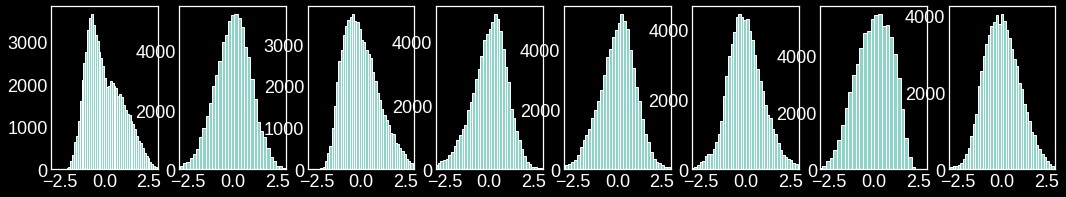

In [11]:
# Centering data?
#labels -= np.mean(labels, axis=1)
#labels /= np.std(labels, axis=1)

# Input range histogram: Is it standardized distribution?
plt.rcParams['figure.figsize'] = [18, 3]
plt.figure()
for c in range(n_cell):
    ax = plt.subplot(1, n_cell, c+1)
    ax.hist(labels[c], bins=50, ec='w');
    ax.set_xlim([-3,3])

In [ ]:
# LN model
model_r = my.LN_model_summary(labels, stim, n_testset=5000)
#plt.title
#plt.text(2*width-0.5+i*spacing, r[i]['training']+0.02, '%.2f'%r[i]['training'], fontsize=fsize-3)
#plt.text(2*width+0.5+i*spacing, r[i]['test']+0.02, '%.2f'%r[i]['test'], fontsize=fsize-3)

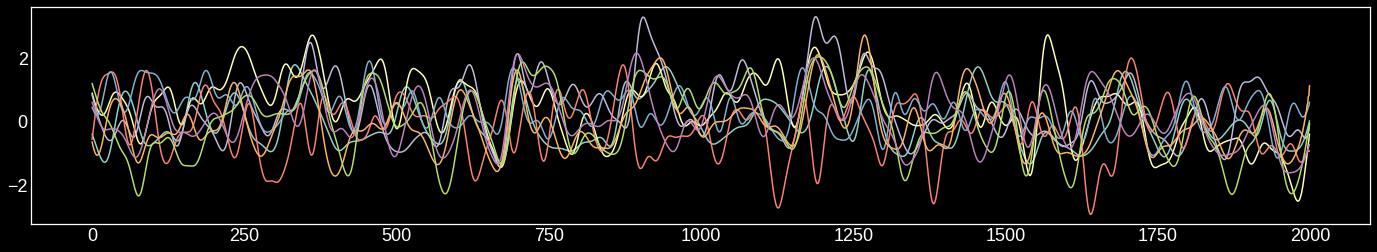

In [133]:
# Trace comparison under same stimulus
#
plt.figure(figsize=(24,4))
for i in range(n_cell):
    plt.plot(labels[i][-2000:])
    # legend?

### CNN modeling on Dongsoo intracellular data

label : (8, 71900)       - Cell id is first
Cell 1: w/ training data (0.631 and 0.628), w/ test data (0.369 and 0.368)


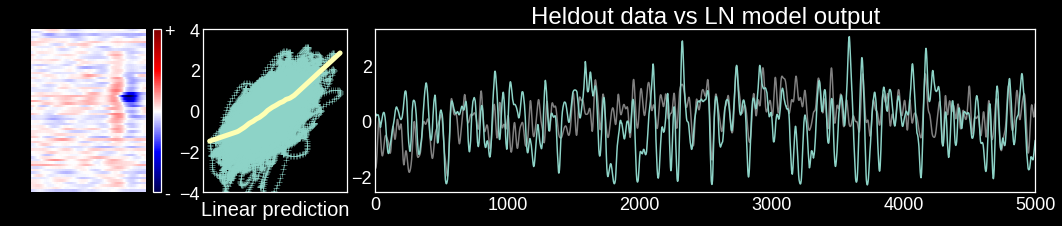

['training', 'test', 'test2']
['L', 'LN']
Cells were selected..
 stim : (71660, 64, 240)
label : (71660, 1)       - Truncated and transposed. Time dim was put first.


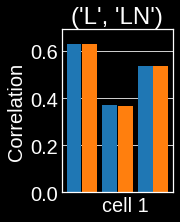

In [14]:
#
labels = [data[i]['vol'] for i in range(len(data))] # List
labels = np.array(labels)                       
print('label :',labels.shape, '      - Cell id is first')

# cell selection
print('Cells were selected..')
labels = labels[4]
labels = labels[None,:]
my.LN_model_summary(labels, stim, n_testset=5000)

# Transpose & Truncated
labels = labels.T
truncated_labels = labels[rolling_size:]
print('rolled stim :', rolled_stim.shape)
print('      label :', truncated_labels.shape, '      - Truncated and transposed. Time dim was put first.')

# CNN multi-layer modeling using pytorch (from optical recording data)

### Rolled-stim and reshape labels to (Frames, cell id)

In [38]:
import mymodel as mm

In [39]:
# rolled_stim for CNN model
# rolling size = correlation size
rolling_size = 35

In [40]:
rolled_stim = deepretina.experiments.rolling_window(stim, rolling_size)
rolled_stim = np.rollaxis(rolled_stim, axis=2, start=1)

In [41]:
# label (Frames, cell id). Truncated.
labels = resp.T
truncated_labels = labels[rolling_size:]
print('rolled stim :', rolled_stim.shape)
print('      label :', truncated_labels.shape, '      - Truncated and transposed. Time dim was put first.')

rolled stim : (16189, 24, 35)
      label : (16189, 5)       - Truncated and transposed. Time dim was put first.


In [58]:
# validation set split
k = 2000

# Data import to pytorch
y = torch.from_numpy(truncated_labels).float()
x = torch.from_numpy(rolled_stim).float()
#
assert len(y) == len(x), "Data number mismatch."
#
# Add channel dimension for image (x) for convolution operation
x = x.unsqueeze(1)
#
n_cell = y.size(1)
D_stim = x.shape[1:]
print('(ch, dim1, dim2, ...):', D_stim, ' If images are gray scale? ch should be 1.')

# Split data
x = {'train': x[:-k],
       'val': x[-k:]}
y = {'train': y[:-k],
       'val': y[-k:]}
#
dataloaders = {d: DataLoader(TensorDataset(x[d],y[d]), batch_size=32, shuffle=True)
              for d in ['train', 'val']}
dataset_sizes = {d: len(x[d]) for d in ['train', 'val']}

(ch, dim1, dim2, ...): torch.Size([1, 24, 35]) If images are gray scale? ch should be 1.


In [59]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [61]:
a = torch.randn(2,4)
print(a)

tensor([[-0.3069, -1.2742,  1.8365, -0.3796],
        [-1.3183,  0.6133,  0.5499, -0.8262]])


In [62]:
a.requires_grad?

Type:        bool
String form: False
Docstring:  
bool(x) -> bool

Returns True when the argument x is true, False otherwise.
The builtins True and False are the only two instances of the class bool.
The class bool is a subclass of the class int, and cannot be subclassed.


In [ ]:
from torch.optim import lr_scheduler
# Global parameters:
    # device
    # dataloaders['train','val']

# 2019 0225 new train function
def train_model(model, optimizer, scheduler, num_epochs=25, coeff_L1=1e-4, model_name='test-model', save='./checkpoints'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0     # validation set evaluation
    
    loss_log = []
    loss_min = 1e10    # the worst loss
    
    if not os.path.exists(save):
        os.mkdir(save)
    
    ax = plt.subplot(111)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    
        # Each epoch round has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode. .train() in my model??
            else:
                model.eval()   # Set model to evaluate mode. .eval() in my model?? 
            
            # Epoch loss and corrects initialization.
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): ## with vs if ?????
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # 2nd output? index for max value.
                    loss = criterion(outputs, labels) # Bimodal classification. loss computes between output vector (not predictor) and labels. 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # .item() converts tensor to python scalar. 
                running_corrects += torch.sum(preds == labels.data) # number of corrects.
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # blank line between epoch result
        print() 
        
        # Training pahse
        for x_batch, y_batch in dataloader:

            y_pred = model(x_batch)

            # Additional regularization
            L1_loss = 0
            L1_loss = model.conv1.weight.abs().sum()
            #for param in model.parameters():
            #    L1_loss += param.abs().sum()
                #L1_loss += model.conv2.weight.abs().sum()
            
            # loss of each batch
            loss = nn.functional.mse_loss(y_pred, y_batch) + coeff_L1 * L1_loss
                # Don't need to track intermedicate values.
                # loss = (y_pred - y).pow(2).sum()
            loss.backward() # compute gradient of loss with respect to all model parameters.
            optimizer.step()      # update params. optimizer knows learning_rate
            optimizer.zero_grad() # zero gradient
        
        # Loss print-out
        loss_log.append(loss.data)
        if epoch % 1 == 0:
            ax.plot(loss_log)
            print('Epoch %d  Loss %.4f' % (epoch+1, loss_log[epoch]))
            
        # Model evaluation phase
        # by validation data set (or simply the lowest loss model )   
               
        # Save model if it is better
        if loss.data <= loss_min:
            loss_min = loss
            best_model_wts = copy.deepcopy(model.state_dict())
            io.save_checkpoint(model, epoch, loss, optimizer, save, model.name) # exp_id = model_name
            #torch.save(model.state_dict(), filename + '-loss-min--epoch-%d' % epoch)
     
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest loss: {:4f}'.format(loss_min))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_log

In [54]:
import retio as io
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
# criterion(outputs, labels)? pass function reference?
def train_model_mse_loss(model, dataloader, optimizer, num_epoch=25, coeff_L1=1e-4, model_name='test-model', save='./checkpoints'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    val_r_history = [] # corr r with validation set
    loss_log = []
    loss_min = 1e10    # the worst loss
    
    if not os.path.exists(save):
        os.mkdir(save)
    
    #filename = model_name + '-' + datetime.datetime.now().strftime('%Y-%m-%d-h%H-m%M')
    
    ax = plt.subplot(111)
    
    for epoch in range(num_epoch):
        # Training pahse
        for x_batch, y_batch in dataloader:

            y_pred = model(x_batch)

            # Additional regularization
            L1_loss = 0
            L1_loss = model.conv1.weight.abs().sum()
            #for param in model.parameters():
            #    L1_loss += param.abs().sum()
                #L1_loss += model.conv2.weight.abs().sum()
            
            # loss of each batch
            loss = nn.functional.mse_loss(y_pred, y_batch) + coeff_L1 * L1_loss
                # Don't need to track intermedicate values.
                # loss = (y_pred - y).pow(2).sum()
            loss.backward() # compute gradient of loss with respect to all model parameters.
            optimizer.step()      # update params. optimizer knows learning_rate
            optimizer.zero_grad() # zero gradient
        
        # Loss print-out
        loss_log.append(loss.data)
        if epoch % 1 == 0:
            ax.plot(loss_log)
            print('Epoch %d  Loss %.4f' % (epoch+1, loss_log[epoch]))
            
        # Model evaluation phase
        # by validation data set (or simply the lowest loss model )   
               
        # Save model if it is better
        if loss.data <= loss_min:
            loss_min = loss
            best_model_wts = copy.deepcopy(model.state_dict())
            io.save_checkpoint(model, epoch, loss, optimizer, save, model.name) # exp_id = model_name
            #torch.save(model.state_dict(), filename + '-loss-min--epoch-%d' % epoch)
     
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest loss: {:4f}'.format(loss_min))
    #print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_log

In [47]:
# split into taining and test set
# x,y : training set 
k = 2000 # testset size
#
x_stim  = rolled_stim[:-k]         # inputs (x) for training.
test_stim  = rolled_stim[-k:]
y_label = truncated_labels[:-k]    # labels (y) for training.
test_label = truncated_labels[-k:] # Don't need to import to pytorch??

In [48]:
# Data import to pytorch, cast data to float (or cast model to double)
y = torch.from_numpy(y_label).float()
x = torch.from_numpy(x_stim).float()
x_test = torch.from_numpy(test_stim).float()
# Add channel dimension for convolution
x = x.unsqueeze(1)
x_test = x_test.unsqueeze(1)
print(rolled_stim.shape)
print(x.shape)
print(y.shape)
#
D_stim = x.shape[1:]
print('stim(x) (ch, dim1, dim2, ...):', D_stim, 'gray stim? ch = 1')
n_cell = y.size(1)

# device
DEVICE = torch.device('cuda')
if torch.cuda.is_available():
    x = x.cuda(DEVICE) # x.to(DEVICE)
    y = y.cuda(DEVICE) # y.to(DEVICE)
    x_test = x_test.cuda(DEVICE)

(16189, 24, 35)
torch.Size([14189, 1, 24, 35])
torch.Size([14189, 5])
stim(x) (ch, dim1, dim2, ...): torch.Size([1, 24, 35]) gray stim? ch = 1


In [27]:
torch.cuda.is_available()

True

In [34]:
# Data import to pytorch, cast data to float (or cast model to double)
y = torch.from_numpy(y_label).float()
x = torch.from_numpy(x_stim).float()
x_test = torch.from_numpy(test_stim).float()
# Add channel dimension for convolution
x = x.unsqueeze(1)
x_test = x_test.unsqueeze(1)
print(rolled_stim.shape)
print(x.shape)
print(y.shape)
#
D_stim = x.shape[1:]
print('stim(x) (ch, dim1, dim2, ...):', D_stim, 'gray stim? ch = 1')
n_cell = y.size(1)

# device
DEVICE = torch.device('cuda')
if torch.cuda.is_available():
    x = x.cuda(DEVICE) # x.to(DEVICE)
    y = y.cuda(DEVICE) # y.to(DEVICE)
    x_test = x_test.cuda(DEVICE)

(16189, 24, 35)
torch.Size([14189, 1, 24, 35])
torch.Size([14189, 5])
stim(x) (ch, dim1, dim2, ...): torch.Size([1, 24, 35]) gray stim? ch = 1


In [35]:
ifi*15

array([0.516045])

In [74]:
import torchvision

Type:        module
String form: <module 'torchvision.transforms' from '/home/juyoung/.local/lib/python3.6/site-packages/torchvision/transforms/__init__.py'>
File:        ~/.local/lib/python3.6/site-packages/torchvision/transforms/__init__.py
Docstring:   <no docstring>


D_stim : torch.Size([1, 24, 35])
n_cell : 5
Epoch 1  Loss 0.9341
Saved!
Epoch 2  Loss 0.8891
Saved!
Epoch 3  Loss 0.8556
Saved!
Epoch 4  Loss 0.8257
Saved!
Epoch 5  Loss 0.8017
Saved!
Epoch 6  Loss 0.7836
Saved!
Epoch 7  Loss 0.7716
Saved!
Epoch 8  Loss 0.7643
Saved!
Epoch 9  Loss 0.7599
Saved!
Epoch 10  Loss 0.7576
Saved!
Epoch 11  Loss 0.7569
Saved!
Epoch 12  Loss 0.7569
Epoch 13  Loss 0.7572
Epoch 14  Loss 0.7574
Epoch 15  Loss 0.7573
Epoch 16  Loss 0.7572
Epoch 17  Loss 0.7570
Epoch 18  Loss 0.7566
Saved!
Epoch 19  Loss 0.7559
Saved!
Epoch 20  Loss 0.7550
Saved!
Epoch 21  Loss 0.7538
Saved!
Epoch 22  Loss 0.7524
Saved!
Epoch 23  Loss 0.7508
Saved!
Epoch 24  Loss 0.7489
Saved!
Epoch 25  Loss 0.7469
Saved!
Epoch 26  Loss 0.7448
Saved!
Epoch 27  Loss 0.7426
Saved!
Epoch 28  Loss 0.7402
Saved!
Epoch 29  Loss 0.7378
Saved!
Epoch 30  Loss 0.7351
Saved!
Epoch 31  Loss 0.7321
Saved!
Epoch 32  Loss 0.7288
Saved!
Epoch 33  Loss 0.7254
Saved!
Epoch 34  Loss 0.7218
Saved!
Epoch 35  Loss 0.7180

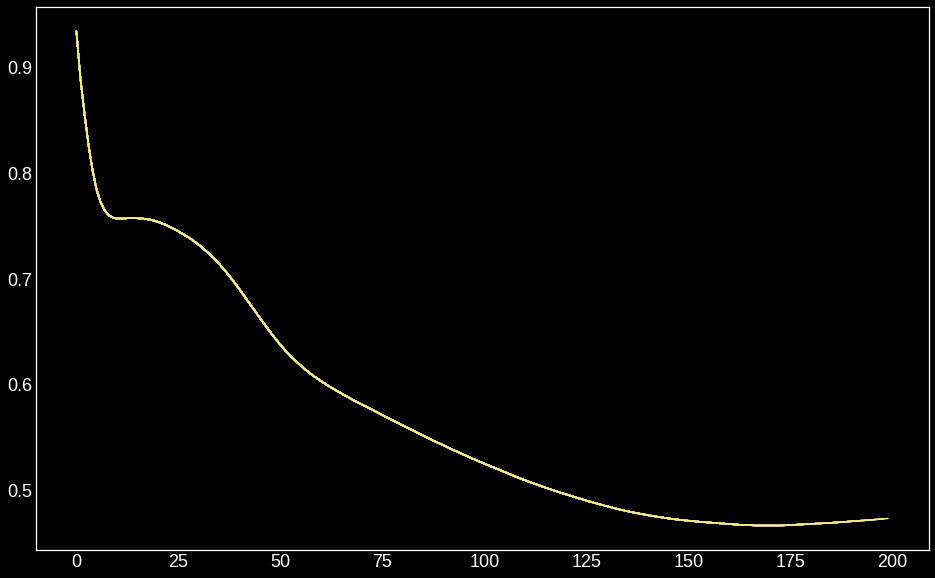

In [61]:
# Model Training
importlib.reload(mm)
importlib.reload(my)
#checkpoint_dir = '/home/juyoung/Modules/1d-whitenoise-models/model-checkpoints/'

# 1st layer hidden unit filter size
num_types = 4
temporal = 15
spacial = 7
space_stride_ = 1
#
learning_rate = 5e-4
coeff_L1_loss = 5e-4   # encourages to be sparse.
coeff_L2_loss = 1e-4
#
D_stim = x.shape[1:]
n_cell = y.size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)
#
#model = mm.SimpleModel(D_stim, n_cell)
#model = mm.LN_TemConv(D_stim, 1, n_cell, temp_filter_size = np.int(0.2 / ifi_upsampled)) # Just tem conv after spatiotemporal pooling/nonlinearity.
model = mm.CNN_2layer(D_stim, num_types, n_cell, temp_filter_size=temporal, space_filter_size=spacial, space_stride=space_stride_)
#
if torch.cuda.is_available():
    model.cuda(DEVICE)
    
# Data wrapper & optimizer
loader = DataLoader(TensorDataset(x,y), batch_size=32, shuffle=False)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2_loss)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay = coeff_L2_loss)

# Model Training
model_result, loss_log = train_model_mse_loss(model, loader, optimizer, num_epoch=200, coeff_L1=coeff_L1_loss)

### we need downsampling!!!!

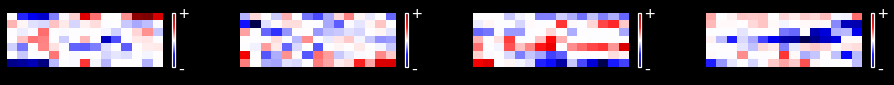

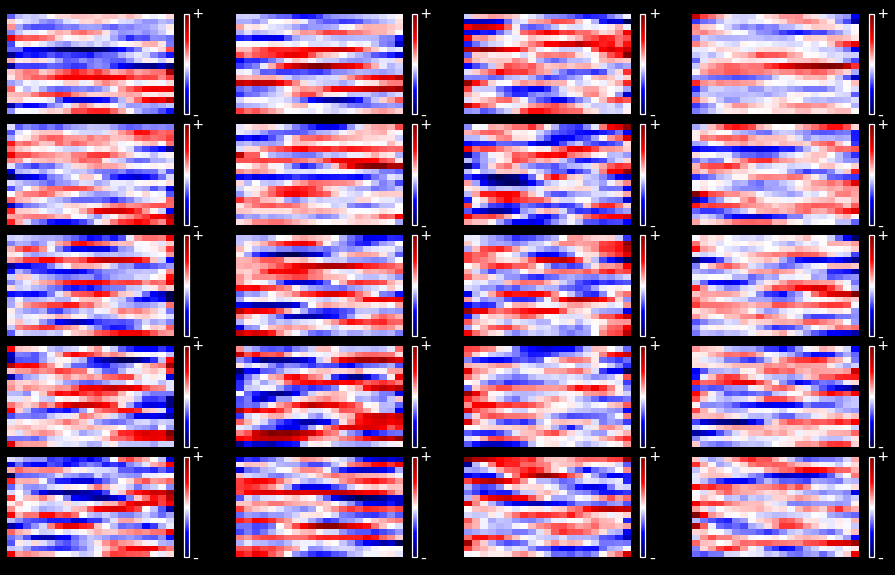

In [60]:
model = model_result
importlib.reload(my)
# model weight
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [4*num_types_1st, 1];
my.plot_kernels_out_ch_cols(w_conv1)
#plt.title('L1 reg %.1e,   L2 reg %.1e' % (coeff_L1, coeff_L2))
plt.rcParams['figure.figsize'] = [16, 2*n_cell];
my.plot_kernels_in_ch_cols(w_conv2)

In [32]:
#def model_summary(model, dataset):

# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]

# model_r
model_name = "LN_Conv"
r = my.model_r_init(model_name, n_cell=y.size(1))

# loop over cell.
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    #print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    #r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))
    r[i]["training"][model_name] = cc_training[0]
    r[i]["test"][model_name] = cc_test[0]

# bar graph
ax = model_r_bar_plot(r, dataset=['training','test'], models=[model_name])
plt.sca(ax)
plt.title('LN + temporal Conv')    

# Model weight RF visualization
plt.rcParams['figure.figsize'] = [4*num_types_1st, 4];
my.plot_kernels_out_ch_cols(w_conv1)
plt.title('L1 reg %.1e,   L2 reg %.1e' % (coeff_L1, coeff_L2))
plt.rcParams['figure.figsize'] = [16, 2*n_cell];
my.plot_kernels_in_ch_cols(w_conv2)
#plt.title('L1 reg %.1e,   L2 reg %.1e' % (coeff_L1, coeff_L2))

# Model rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)

# Plot trace
i_cell = 0
y_model_test -= np.mean(y_model_test, axis=0)
y_model_test /= np.std(y_model_test, axis=0)
plt.rcParams['figure.figsize'] = [18, 1];
#fig = plt.figure()
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(labels[k:k+size, i_cell])
plt.plot(y_model_test[:, i_cell])
ax.set_xlim([0, 1000])
plt.title('Heldout data and LN output traces')

RuntimeError: CUDA error: out of memory

### 1 layer torch model 

In [37]:
class SimpleModel(nn.Module):
    def __init__(self, D_stim, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        # D_out: # of cells (or ROIs)
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(D_stim[0], D_out,  kernel_size = D_stim[1:])
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)    # x.size(0) = batch number
        #x = x.view(-1, D_out)        # [batch #, output cell#]
        #return torch.tanh(x) # For RELU, self.conv1(x).clamp(min=0) For SELU, nn.functional.selu(x)
        #x = nn.functional.softplus(x)
        x = torch.tanh(x)
        # Additional conv for temporal kinetics of Ca indicator. No linear combination over channels.
        return x

D_stim : torch.Size([1, 64, 240])
n_cell : 4
Epoch 0  Loss 0.9511
Epoch 10  Loss 0.3555
Epoch 20  Loss 0.3280
Epoch 30  Loss 0.3251


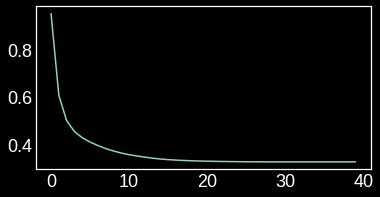

In [38]:
# Data wrapper
loader = DataLoader(TensorDataset(x,y), batch_size=8)
#
D_stim = x.shape[1:]
n_cell = y.size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)
#
num_epoch = 40
learning_rate = 1e-5
coeff_L1 = 1e-3   # encourages to be sparse.
coeff_L2 = 5e-4
loss_log = np.zeros((num_epoch))

model = SimpleModel(D_stim, n_cell)

if torch.cuda.is_available():
    model.cuda(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)

#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
                
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += coeff_L1 * param.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + L1_loss

            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient

    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 10 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))

# Plot loss
plt.rcParams['figure.figsize'] = [6, 3];
plt.plot(loss_log)

# Load best model?

In [53]:
importlib.reload(my)
np.set_printoptions(precision=2)

Correlation r 
	 to training data     to held-out data
Cell 0: 	    0.68, 		 0.41
Cell 1: 	    0.80, 		 0.61
Cell 2: 	    0.69, 		 0.50
Cell 3: 	    0.68, 		 0.32


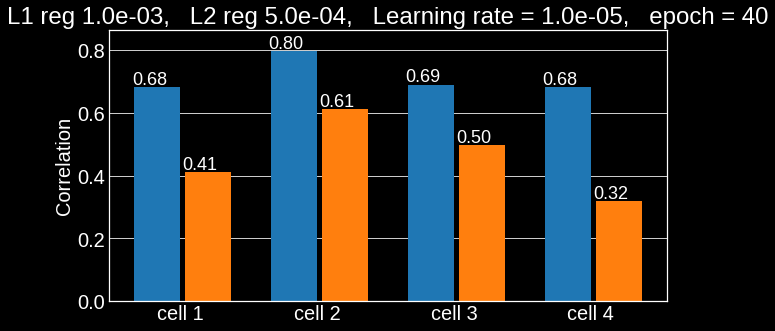

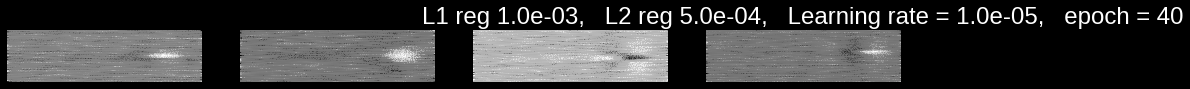

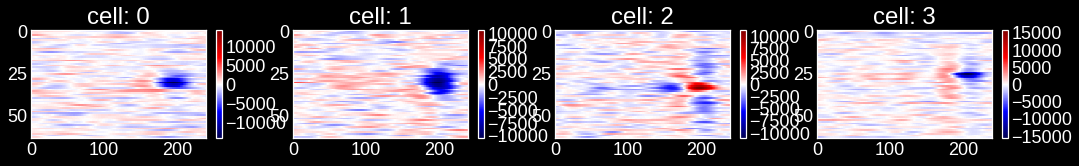

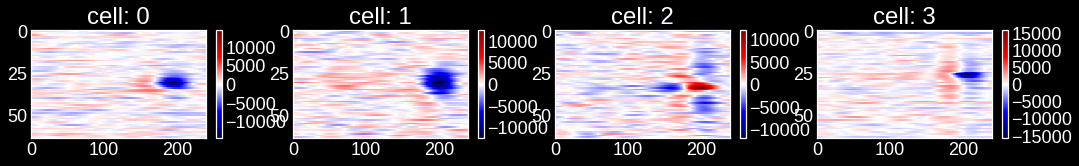

In [40]:
# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv = model.conv.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]
#
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))

# bar graph
pos = list(range(len(r[0].keys()))) 
width = 0.9
spacing = 3*width
fig, ax = plt.subplots(figsize=(10,5))
fsize = 20
for i in range(n_cell):
    plt.bar([p + i*spacing for p in pos],  r[i].values(), width, color=['#1f77b4', '#ff7f0e'])
    #plt.text([p-0.5 + i*spacing for p in pos], [v+0.01 for v in r[i].values()], ['%.2f' %v for v in r[i].values()], color=['#1f77b4', '#ff7f0e'])
    plt.text(-0.5+i*spacing, r[i]['training']+0.01, '%.2f'%r[i]['training'], fontsize=fsize-2)
    plt.text(0.5+i*spacing, r[i]['test']+0.01, '%.2f'%r[i]['test'], fontsize=fsize-2)
ax.set_ylabel('Correlation', fontsize=fsize)
ybottom, ytop = plt.ylim()
ax.set_ylim(top = ytop + 0.03)
ax.set_xticks([i*spacing + width/2. for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %(i+1) for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
#fig.patch.set_facecolor((1, 1, 1))
plt.title('L1 reg %.1e,   L2 reg %.1e,   Learning rate = %.1e,   epoch = %d' % (coeff_L1, coeff_L2, learning_rate, num_epoch))
    
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [16, 4];
my.plot_kernels_out_ch_cols(w_conv)
plt.title('L1 reg %.1e,   L2 reg %.1e,   Learning rate = %.1e,   epoch = %d' % (coeff_L1, coeff_L2, learning_rate, num_epoch))

# Model rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)


#### 1 filter and Nonlinear + Ca indicator block

In [367]:
class LN_TemConv(nn.Module):
# 2-layer model: Conv1 (over entire space) + Conv2(= FC)
    def __init__(self, D_stim, H, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        #     H  : num of layer1 channels
        # D_out  : num of cells (or ROIs)
        
        max_space_filtering    = D_stim[1] # conv over entire space
        max_temporal_filtering = np.int(0.2 / ifi_upsampled);       # 200 ms
        k1 = [max_space_filtering, max_temporal_filtering] # subunit spatiotemporal filter. # [space, time] ~ [40*7 um, (1/15Hz)*6=400 ms]
        #k2 = [D_stim[1]-max_space_filtering+1, max_temporal_filtering] # filter for integrating subunits.
        k2 = [D_stim[1]-max_space_filtering+1, D_stim[2]-max_temporal_filtering+1] # filter for integrating subunits.

        super(LN_TemConv, self).__init__()
        self.relu = nn.ReLU(inplace=True) # inplace=True: update the input directly. 
        self.softplus = nn.Softplus()
        self.conv1 = nn.Conv2d(D_stim[0], H, kernel_size = k1)
        self.conv2 = nn.Conv2d(H,     D_out, kernel_size = k2) # equivalent to FC layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.softplus(x)   # rectifying nonlinearity.
        x = self.conv2(x)      # Temporal convolution.
        # x = (batch, ch, dim1, dim2)
        assert x.size(2) == 1 # Final dim1 (space) convolution should integrate all subunits.
        assert x.size(3) == 1 # Final dim1 (space) convolution should integrate all subunits.
        x = x.view(x.size(0), -1)
        x = torch.tanh(x)     # Final nonlinearity
        return x

In [335]:
D_stim = x.shape[1:]
print(D_stim)

torch.Size([1, 24, 35])


Epoch 0  Loss 2.4060
Epoch 10  Loss 2.2509
Epoch 20  Loss 2.0570
Epoch 30  Loss 1.9899
Epoch 40  Loss 2.0047
Epoch 50  Loss 2.0296
Epoch 60  Loss 2.0514
Epoch 70  Loss 2.0709
Epoch 80  Loss 2.0883
Epoch 90  Loss 2.1027


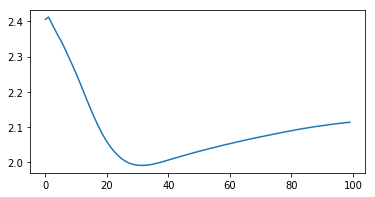

In [374]:
# data wrapper
n_cell = 1
i_cell = 0
y_single = y[:,i_cell].unsqueeze(1)
loader = DataLoader(TensorDataset(x, y_single), batch_size=8)               
#
D_stim = x.shape[1:]

#
model = LN_TemConv(D_stim, 1, n_cell)
if torch.cuda.is_available():
    model.cuda(DEVICE)
#
num_epoch = 50
learning_rate = 1e-4
coeff_L1 = 1e-3   # encourages to be sparse.
coeff_L2 = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)
loss_log = np.zeros((num_epoch))
#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
        
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += coeff_L1 * param.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + L1_loss
            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient
    
    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 10 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))

# Plot loss 
plt.rcParams['figure.figsize'] = [6, 3];
plt.plot(loss_log)

In [ ]:
# model output
y_model_training = model(x).cpu().detach().numpy()
y_model_test     = model(x_test).cpu().detach().numpy()
rf_model = my.corr_with_rolled_stim(x_stim, y_model_training)
rf_label = my.corr_with_rolled_stim(x_stim, y_label)
# model weight
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()

# Correlation to training data
keys = ['training','test']
values = [0, 0]
r = [dict(zip(keys, values)) for c in range(n_cell)]
#
print('Correlation r \n\t to training data     to held-out data')
for i in range(y_model_training.shape[1]):
    cc_training = pearsonr(y_label[:, i], y_model_training[:, i])
    cc_test  = pearsonr(test_label[:, i], y_model_test[:, i])
    print('Cell %d: \t    %.2f, \t\t %.2f' % (i, cc_training[0], cc_test[0]))
    r[i] = dict(zip(keys, [cc_training[0], cc_test[0]]))

# bar graph
pos = list(range(len(r_LN_output[0].keys()))) 
width = 0.9
spacing = 3*width
fig, ax = plt.subplots(figsize=(10,5))
fsize = 20
for i in range(n_cell):
    plt.bar([p + i*spacing for p in pos],  r[i].values(), width, color=['#1f77b4', '#ff7f0e'])
ax.set_ylabel('Correlation', fontsize=fsize)
ax.set_xticks([i*spacing + width/2. for i in range(n_cell)])
ax.set_xticklabels(['cell %d' %i for i in range(n_cell)])
ax.tick_params(axis='both', labelsize=fsize)
ax.tick_params(axis='x', length=0)
ax.yaxis.grid()
fig.patch.set_facecolor((1, 1, 1))
    
    
# Model weight RF visualization
plt.rcParams['figure.figsize'] = [16, 4];
my.plot_kernels_out_ch_cols(w_conv1)
my.plot_kernels_out_ch_cols(w_conv2)

# Model rev corr
plt.rcParams['figure.figsize'] = [3, 2];
my.rf_imshow(rf_model)

# Label rev corr
plt.rcParams['figure.figsize'] = [18, 2];
my.rf_imshow(rf_label)


In [43]:
class SimpleModel2(nn.Module):
# 2-layer model: Conv1 + Conv2(= FC)
    def __init__(self, D_stim, H, D_out):
        # D_stim : [ch, dim1, dim2] e.g. [color, space, time]
        #     H  : num of channels (types in conv1 layer) 
        # D_out  : num of cells (or ROIs)
        
        max_space_filtering    = 7; # 500 um 
        max_temporal_filtering = 15; # 2/3 s
        k1 = [max_space_filtering, max_temporal_filtering] # subunit spatiotemporal filter. # [space, time] ~ [40*7 um, (1/15Hz)*6=400 ms]
        #k2 = [D_stim[1]-max_space_filtering+1, max_temporal_filtering] # filter for integrating subunits.
        k2 = [D_stim[1]-max_space_filtering+1, D_stim[2]-max_temporal_filtering+1] # filter for integrating subunits.

        super(SimpleModel2, self).__init__()
        self.relu = nn.ReLU(inplace=True) # inplace=True: update the input directly. 
        self.softplus = nn.Softplus()
        self.conv1 = nn.Conv2d(D_stim[0], H, kernel_size = k1, stride = 1)
        self.conv2 = nn.Conv2d(H,     D_out, kernel_size = k2, stride = 1) # equivalent to FC layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.softplus(x)     # rectifying nonlinearity.
        x = self.conv2(x)    # saturating nonlinearity.
        # x = (batch, ch, dim1, dim2)
        assert x.size(2) == 1 # Final dim1 (space) convolution should integrate all subunits.
        assert x.size(3) == 1 # Final dim1 (space) convolution should integrate all subunits.
        x = x.view(x.size(0), -1)
        x = torch.tanh(x)
        return x

In [44]:
# Model Training
#
model_name = 'CNN-2layer'
checkpoint_dir = '/home/juyoung/Modules/1d-whitenoise-models/model-checkpoints/'
filename = checkpoint_dir + model_name + '-' + datetime.datetime.now().strftime('%Y-%m-%d-h%H-m%M')

# Data wrapper
loader = DataLoader(TensorDataset(x,y), batch_size=8)
#
D_stim = x.shape[1:]
n_cell = y.size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)

#
num_epoch = 500
num_types_1st = 4
learning_rate = 5e-4
coeff_L1 = 2e-4   # encourages to be sparse.
coeff_L2 = 1e-4

#
model = SimpleModel2(D_stim, num_types_1st, n_cell)

if torch.cuda.is_available():
    model.cuda(DEVICE)

#    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2)

D_stim : torch.Size([1, 64, 240])
n_cell : 4


In [78]:
#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
        
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += param.abs().sum()
            #L1_loss += model.conv2.weight.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + coeff_L1 * L1_loss
            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient

    if epoch == 1:
        loss_min = loss
        
    # save model
    if loss <= loss_min:
        #torch.save(model.state_dict(), filename+'-epoch-%d'%epoch)
        torch.save(model.state_dict(), filename+'-loss-min')
    
    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 5 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))
        ax = plt.subplot(111)
        ax.plot(loss_log)
        plt.show()
        
# Plot loss 
#plt.rcParams['figure.figsize'] = [6, 3];
ax.plot(loss_log)
plt.show()

D_stim : torch.Size([1, 64, 240])
n_cell : 8


KeyboardInterrupt: 

RuntimeError: CUDA error: out of memory

In [509]:
importlib.reload(my)
np.set_printoptions(precision=2)

In [ ]:
# 4D tensor visualization for pytorch model
plt.rcParams['figure.figsize'] = [12, 4];    
w_conv1 = model.conv1.weight.data.cpu().numpy()
w_conv2 = model.conv2.weight.data.cpu().numpy()
plot_kernels_out_ch_cols(w_conv1)
plt.rcParams['figure.figsize'] = [16, 12];
plot_kernels_in_ch_cols(w_conv2)

# model output: STA and correlation
y_model = model(x).cpu().detach().numpy()
model_rf = corr_with_rolled_stim(rolled_stim, y_model)
plt.rcParams['figure.figsize'] = [6, 3];
print('Rev correlation of Model output')
rf_imshow(model_rf)

### CNN TF model

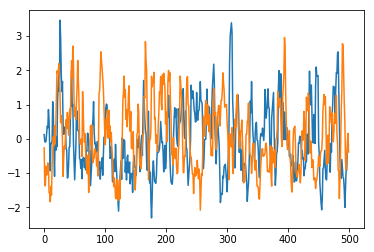

In [110]:
# Does Test label actually look similar to train label?
c = 0
data_size = 500
training_set_size = 14000
plt.plot(truncated_labels[data_after:data_after+data_size, c])
plt.plot(truncated_labels[training_set_size:training_set_size+data_size, c])

In [ ]:
# Center labels ?
truncated_labels -= np.mean(truncated_labels, axis=0)
truncated_labels /= np.std(truncated_labels, axis=0)

In [108]:
# Tf model
tf.reset_default_graph()

In [109]:
np.floor(55000/2000)

27.0

In [110]:
model_labels.shape[1]

2

### All_variables to model again? + perturbation?
Contiribution of i-th filter (or subunit only?)

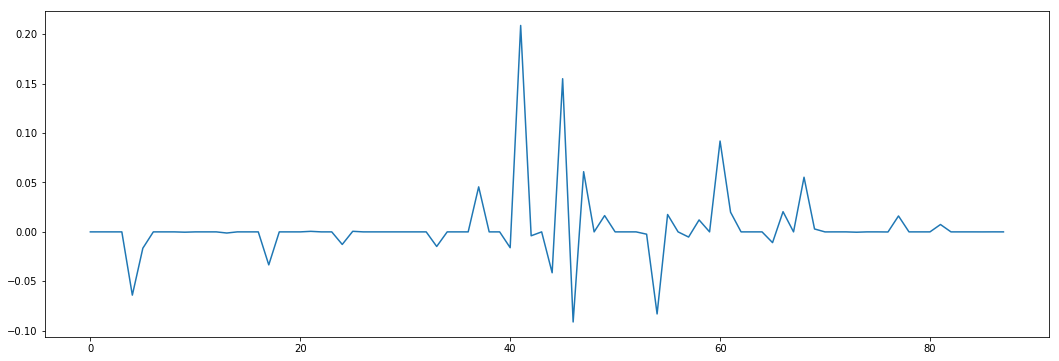

In [50]:
# plt.imshow(all_variables[2][:, 0], aspect='auto', cmap='seismic')
plt.plot(all_variables[2][:, 0])

In [44]:
[a.shape for a in all_variables]

[(3, 35, 4), (4,), (88, 2), (2,)]

In [ ]:
pearsonr(test_out[:1000, 0], test_labels[:1000, 0])

In [ ]:
for i in range(n_cell):
    cc = pearsonr(test_out[:1000, i], test_labels[:1000, i])
    print(cc[0]) # 2nd output is p-value
    plt.figure()
    plt.plot(test_out[:500, i])
    plt.plot(test_labels[:500, i])

In [ ]:
saved_test_out = test_out
saved_test_labels = test_labels

In [ ]:
plt.plot(test_out[:100, 0])
plt.plot(test_labels[:100, 0])

In [ ]:
len(all_variables)

In [ ]:
for v in all_variables:
    print(v.shape)

In [ ]:
plt.imshow(receptive_fields[0])

In [ ]:
test_mse

In [ ]:
test_out.shape

In [ ]:
test_labels.shape

In [ ]:
plt.plot(test_out[:100, 0])
plt.plot(test_labels[:100, 0])

In [ ]:
flattened_layer2.shape

In [ ]:
layer2.get_shape()

# Qualitative comparison

In [ ]:
cell_id = 2

fig = plt.figure(figsize=(1.5, 0.5))
random_start = 6900
# random_start = np.random.choice(9995 - 200)
# m = qualitative_comparison['model'][random_start:random_start+200] - np.mean(qualitative_comparison['model'])
# m /= np.std(qualitative_comparison['model'])
# b = qualitative_comparison['bipolar'][random_start:random_start+200] - np.mean(qualitative_comparison['bipolar'])
# b /= np.std(qualitative_comparison['bipolar'])
m = test_out[:400, cell_id] - np.mean(test_out[:, cell_id])
m /= np.std(test_out[:, cell_id])
b = test_labels[:400, cell_id] - np.mean(test_labels[:400, cell_id])
b /= np.std(test_labels[:, cell_id])

plt.plot(np.linspace(0, 2, 400), b, color='k', linewidth=1)
plt.plot(np.linspace(0, 2, 400), m, color='b', linewidth=2, alpha=0.5)
adjust_spines(plt.gca())

ax = plt.gca()
majorLocator = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plt.xlabel('Seconds (s)')